# Profiling
_Profiling attempts to distinguish the different potential sources of PFAS attribution to our public & private well supplies. The way that we can create a profile of a potential source is by ingesting sampling results (that are most directly attributable to a specific source) through a feature reduction or clustering method to build a vector/model that exemplifies that source._ 

**Hierarchical Clustering (HC)** is used in this notebook to build a profile of the potential sources. This is based on the PCA notebook from Dan and is meant to be combined with his at a later time.

Potential Sources & attributable information:
* Residential Profile: Wastewater/sludge data from wastewater treatment systems
* AFFF Profile: AFFF lab reports
* Other manufacturing sources: Disposal site groundwater supplies


****

In [87]:
import pandas as pd
import numpy as np

## Residential Profile

* Some are <MRL, while some are ND. <MRL means that it was detected, but below standards that we are comfortable with. Should we treat these any differently in our analysis?
    * <span style="color:red">This study uses a threshold to determine where imputation should be done. https://bgc.seas.harvard.edu/assets/ruyle-2021-isolating-the-afff-signature-in-coa.pdf</span>
    
* Is there any filtering we should be doing on the data? Primary/Duplicate?

In [88]:
orig_residential_df = pd.read_csv('Wastewater Treatment Systems Effluent  -  Sludge 2021-08.csv', encoding='iso-8859-1')
residential_df = orig_residential_df.copy()

In [89]:
residential_df.head(10)

,Facility,Sample Collection Date,Sample Field ID,Sample Laboratory ID #,Lab Name,Sample % Solids,Sample PFAS Conc. Units (ng/g dry wt),PFBS,MRL,MDL,...,Unnamed: 114,Unnamed: 115,Unnamed: 116,Unnamed: 117,Unnamed: 118,Unnamed: 119,Unnamed: 120,Unnamed: 121,Unnamed: 122,Unnamed: 123
0,Amesbury WTP,9/9/2020,,,Alpha Analytical,19%,ng/g,<MRL,2.6,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Amesbury WTP,12/2/2020,A49324,L2053716-01,Alpha Analytical,18%,ng/g,ND,2.6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Amesbury WTP,12/2/2020,A49325,L2053716-02,Alpha Analytical,17.8%,ng/g,ND,2.65,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Amesbury WTP,3/3/2021,Primary,NaN,Alpha Analytical,17.0%,ng/g,ND,0.701,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Amesbury WTP,3/3/2021,Duplicate,NaN,Alpha Analytical,17.0%,ng/g,ND,0.709,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Amesbury WTP,6/16/2021,A53246,L2133040-01,AAL,20.4,ng/g,ND,0.579,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Amesbury WTP,6/16/2021,A53247,L2133040-02,AAL,19.6,ng/g,ND,0.611,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Barnhardt,6/2/2020,NaN,NaN,Alpha,NaN,ng/g,ND,3.09,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Barnhardt,6/2/2020,NaN,NaN,Alpha,NaN,ng/g,ND,3.2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Barnhardt,9/3/2020,NaN,NaN,Alpha,15%,ng/g,ND,3.29,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [90]:
# Data has a lot of unnecessary columns, but is generally set up in the correct fashion.
# We want each row to be a sample with each PFAS concentration as columns

unique_vars = ['Facility', 'Sample Collection Date', 'Sample Field ID', 'Sample Laboratory ID #']
pfas_vars = ['PFBS    ', 'PFBA', 'PFDS', 'PFDA', 'PFDoA', 'PFHpA', 'PFHxS', 'PFHxA','PFNA','PFTrDA','PFOSA','PFOA','PFOS','PFPeA','PFTeDA','PFUnA','PFPeS','PFNS','PFTA', 'PFHpS']

In [91]:
mrl_dict = {}
for var in pfas_vars:
    mrl_dict[var] = residential_df.columns[residential_df.columns.get_loc(var) + 1]

## Imputation of Unknown amounts (ND) - INTERMEDIARY
    * ROS will be used to impute the actual amounts that weren't reported due to data censoring. For now use 1/2 the reporting amount. ROS code (in python) is currently not working correctly. Will stick with 1/2 of reporting limit (either regulatory or laboratory, whichever is available and lower).

In [92]:
# Problematic values:  <1.1, <0.34 - need to remove <
residential_df.replace({'<':''}, regex=True, inplace = True)

# Problematic values: Replace all Not tested/reported with 0
residential_df.replace({np.nan : 0,
                        'Not Tested' : 0, 
                        'Not Reported' : 0, 
                        'NT' : 0, 
                        '' : 0,
                        '\xa0' : 0,
                        'Not reported' : 0,
                        'Not tested' : 0,
                        'NS' : 0}, inplace = True)


In [93]:
## As an intermediary (until ROS is complete) - impute those with <MRL, ND, <MD with 1/2 MRL
_less_than_rl = ['MRL', 'ND', 'MD']

In [94]:
residential_df.replace({'MRL' : np.nan})

for pfas in pfas_vars:
    residential_df[pfas] = pd.to_numeric(residential_df[pfas], errors = 'coerce')
    residential_df[mrl_dict[pfas]] = pd.to_numeric(residential_df[mrl_dict[pfas]], errors = 'coerce')
    
    residential_df[pfas] = np.where(residential_df[pfas].isna(), residential_df[mrl_dict[pfas]] / 2, residential_df[pfas])

In [95]:
residential_df = residential_df[unique_vars + pfas_vars]

## Normalize

In [96]:
from sklearn import preprocessing

In [97]:
# Normalization. Make sure the ingested data is normalized.
x = residential_df[pfas_vars].values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
residential_df[pfas_vars] = pd.DataFrame(x_scaled)

# EDA

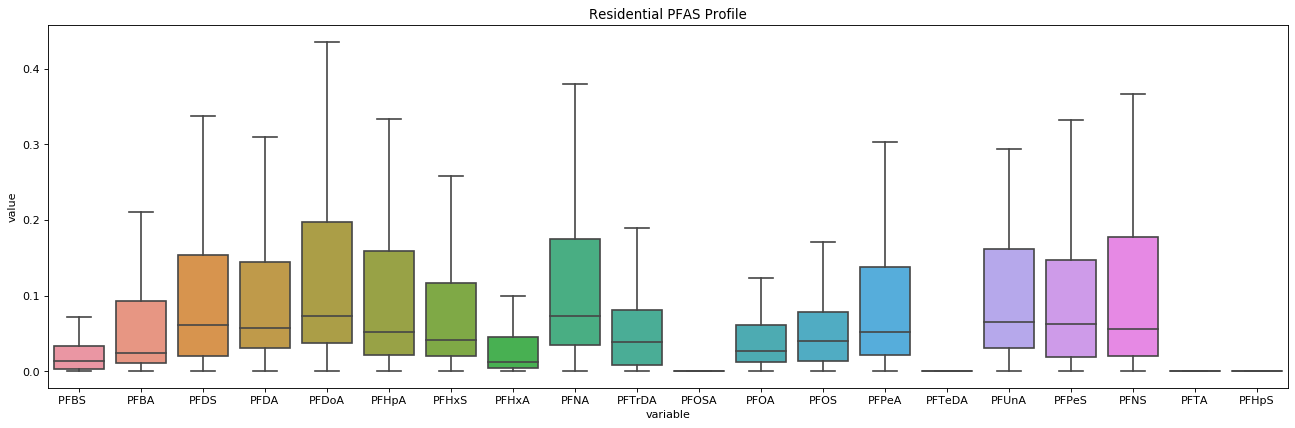

In [188]:
# Should this be in molecular weight order?? - Easier to compare across different sources/samples

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 6), dpi=80)
plt.ylabel('Normalized concentration')
plt.xlabel('PFAS Type')
plt.title('Residential PFAS Profile')

sns.boxplot(x="variable", y="value", data=pd.melt(residential_df[pfas_vars]), showfliers = False)
plt.show()

### HC
* Hierarchical clustering via "Ward" method and euclidean distance.
* Ward method minimizes within-cluster variance.

In [99]:
# Remove NAs
residential_df.dropna(inplace = True)

In [100]:
pfas_vars

['PFBS    ',
 'PFBA',
 'PFDS',
 'PFDA',
 'PFDoA',
 'PFHpA',
 'PFHxS',
 'PFHxA',
 'PFNA',
 'PFTrDA',
 'PFOSA',
 'PFOA',
 'PFOS',
 'PFPeA',
 'PFTeDA',
 'PFUnA',
 'PFPeS',
 'PFNS',
 'PFTA',
 'PFHpS']

In [101]:
residential_df[pfas_vars]

,PFBS,PFBA,PFDS,PFDA,PFDoA,PFHpA,PFHxS,PFHxA,PFNA,PFTrDA,PFOSA,PFOA,PFOS,PFPeA,PFTeDA,PFUnA,PFPeS,PFNS,PFTA,PFHpS
1,0.016667,0.027083,0.096296,0.19000,0.104839,0.027083,0.027083,0.007647,0.627500,0.104839,0.000000,0.078852,0.427857,0.059091,0.000000,0.104839,0.000000,0.000000,0.000000,0.000000
2,0.016987,0.027604,0.098148,0.21450,0.106855,0.027625,0.027625,0.007794,0.703333,0.106855,0.000000,0.089016,0.491429,0.060227,0.000000,0.106855,0.000000,0.000000,0.000000,0.000000
3,0.004494,0.014583,0.051852,0.07700,0.056452,0.029208,0.029208,0.004118,0.204167,0.056452,0.000000,0.030000,0.302857,0.031818,0.000000,0.056452,0.112903,0.112903,0.000000,0.000000
4,0.004545,0.014792,0.052593,0.07750,0.057258,0.029542,0.029542,0.004176,0.200000,0.057258,0.000000,0.033770,0.310714,0.032273,0.000000,0.057258,0.114516,0.114516,0.000000,0.000000
5,0.003712,0.012083,0.042963,0.09400,0.046774,0.024125,0.024125,0.003412,0.149167,0.046774,0.000000,0.012131,0.291429,0.026364,0.000000,0.046774,0.093548,0.093548,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,0.000577,0.000708,0.012889,0.00730,0.010484,0.004833,0.005750,0.000353,0.012083,0.018790,0.017500,0.003246,0.006007,0.002727,0.872093,0.014113,0.007661,0.027500,0.036765,0.294340
208,0.001077,0.003875,0.015852,0.00720,0.009355,0.013750,0.007250,0.001676,0.013750,0.022984,0.021406,0.008016,0.006514,0.010636,0.872093,0.014839,0.009355,0.033629,0.036765,0.358491
209,0.000769,0.035000,0.017333,0.00540,0.008629,0.005750,0.007667,0.000471,0.009500,0.025161,0.023438,0.002361,0.004857,0.003182,0.953488,0.013952,0.010323,0.036774,0.040196,0.392453
210,0.000731,0.035208,0.016667,0.01835,0.008306,0.005500,0.007417,0.000453,0.009167,0.024194,0.022500,0.002377,0.004929,0.001500,0.918605,0.014597,0.009919,0.035403,0.038725,0.377358


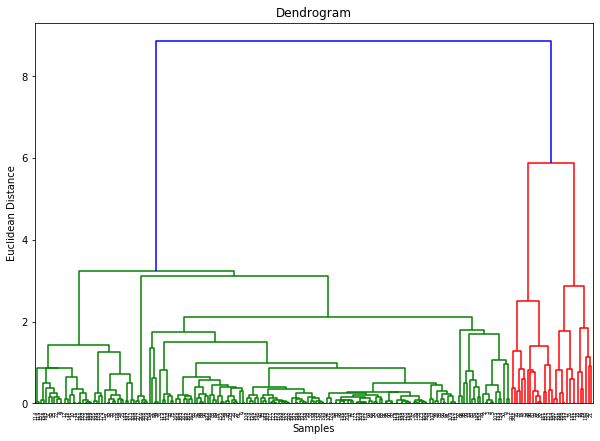

In [256]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))
dend = shc.dendrogram(shc.linkage(residential_df[pfas_vars], method='ward'))
plt.title("Dendrogram")
plt.xlabel("Samples")
plt.ylabel("Euclidean Distance")
plt.show()

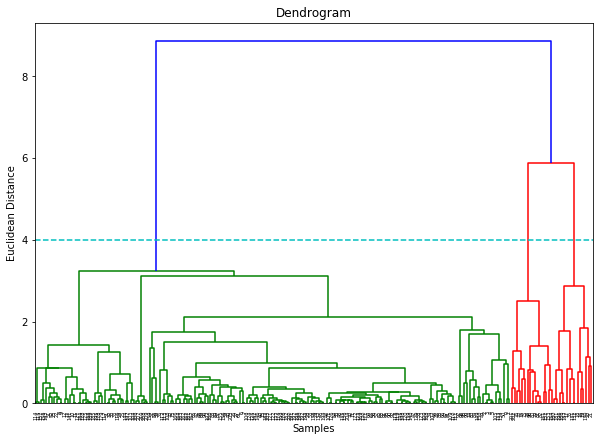

In [284]:
# Determine the optimal # of clusters using the dendrogram.
# Look for the longest vertical line(s) that does not cross another horizontal line.
# That would be the blue line on the left. Hence, if we choose a Euclidean distance
# of 4, we would get three (3) clusters (see cyan dotted line below).
plt.figure(figsize=(10, 7))
dend = shc.dendrogram(shc.linkage(residential_df[pfas_vars], method='ward'))
plt.title("Dendrogram")
plt.xlabel("Samples")
plt.ylabel("Euclidean Distance")
plt.axhline(y=4, color='c', linestyle='--')
# plt.axhline(y=3, color='r', linestyle='--')
# plt.axhline(y=2.75, color='g', linestyle='--')
# plt.axhline(y=2.25, color='b', linestyle='--')
plt.show()

In [259]:
# Predict clusters using agglomerative clustering
from sklearn.cluster import AgglomerativeClustering

# Based on analysis of dendrogram above, we will select three (3) clusters.
clusterHC = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')  
y_hc = clusterHC.fit_predict(residential_df[pfas_vars])

In [280]:
# Visualize clusters in 2D scatter plot. Can only pick up to three compounds at a time,
# but will only plot the first two on the list for 2D scatter plot.
# test = cluster.labels_
y_hc_loc0 = residential_df.iloc[y_hc==0]
y_hc_loc1 = residential_df.iloc[y_hc==1]
y_hc_loc2 = residential_df.iloc[y_hc==2]

pfas_col_num = [3, 5, 7]
pfas_col_names = [pfas_vars[i] for i in pfas_col_num]
# print(pfas_names)

data0 = y_hc_loc0[pfas_col_names]
data1 = y_hc_loc1[pfas_col_names]
data2 = y_hc_loc2[pfas_col_names]
# print(data0)

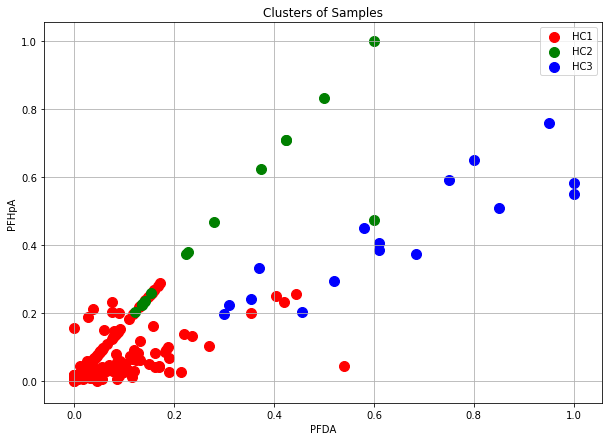

In [281]:
# Plot clusters in 2D
plt.figure(figsize=(10, 7))

# plt.scatter(data0, data1, data2, c=clusterHC.labels_)
plt.scatter(data0.iloc[:, 0], data0.iloc[:, 1], s=100, c='red', label='HC1')
plt.scatter(data1.iloc[:, 0], data1.iloc[:, 1], s=100, c='green', label='HC2')
plt.scatter(data2.iloc[:, 0], data2.iloc[:, 1], s=100, c='blue', label='HC3')

plt.title("Clusters of Samples")
plt.xlabel(pfas_col_names[0])
plt.ylabel(pfas_col_names[1])
plt.legend()
plt.grid(True)

plt.show()

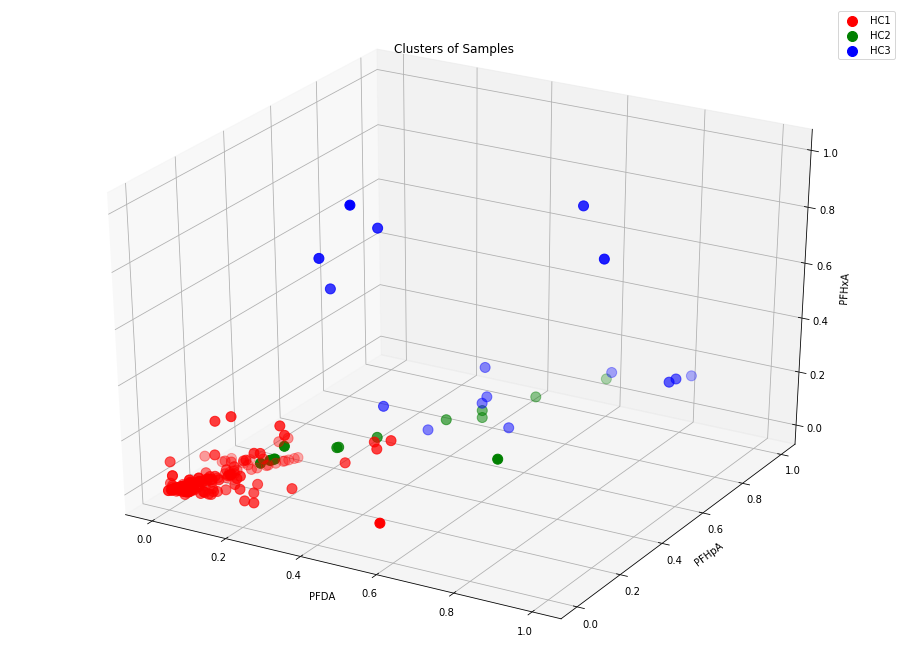

In [283]:
# Plot clusters in 3D
from mpl_toolkits import mplot3d
fig = plt.figure(figsize=(16, 12))
ax = plt.axes(projection ="3d")

# plt.scatter(data0, data1, data2, c=clusterHC.labels_)
ax.scatter3D(data0.iloc[:, 0], data0.iloc[:, 1], data0.iloc[:, 2], s=100, c='red', label='HC1')
ax.scatter3D(data1.iloc[:, 0], data1.iloc[:, 1], data1.iloc[:, 2], s=100, c='green', label='HC2')
ax.scatter3D(data2.iloc[:, 0], data2.iloc[:, 1], data2.iloc[:, 2], s=100, c='blue', label='HC3')

plt.title("Clusters of Samples")
plt.legend()
ax.set_xlabel(pfas_col_names[0])
ax.set_ylabel(pfas_col_names[1])
ax.set_zlabel(pfas_col_names[2])

plt.show()